In [25]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from scipy.linalg import toeplitz
from sklearn.metrics import mean_squared_error
from IPython.display import Audio


In [3]:
path = librosa.example("nutcracker")
Audio(path)

In [4]:
sample, sampling_rate = librosa.load(path)

start = 30
end = 36
sample = sample[int(sampling_rate * start):int(sampling_rate * end)]

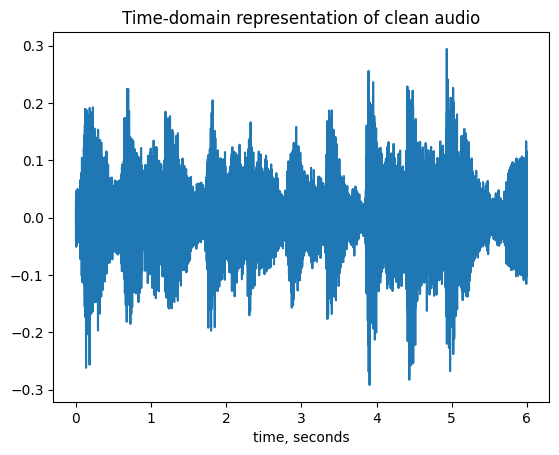

In [5]:
time = np.array(range(sample.shape[0])) / sampling_rate
plt.plot(time, sample)
plt.title('Time-domain representation of clean audio')
plt.xlabel('time, seconds')
plt.show()
Audio(sample, rate=sampling_rate)

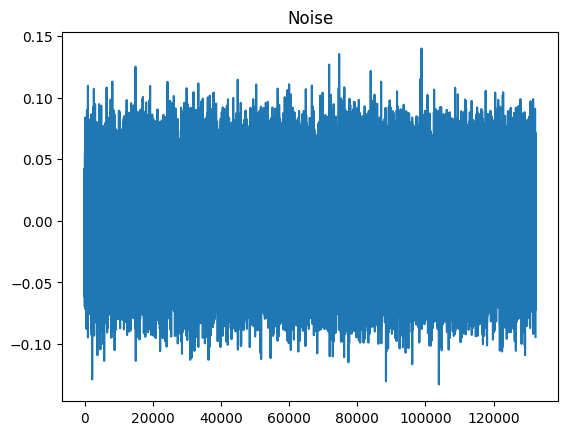

In [6]:
noise = np.random.normal(0, 0.03, sample.shape[0])

plt.plot(noise)
plt.title('Noise')
plt.show()

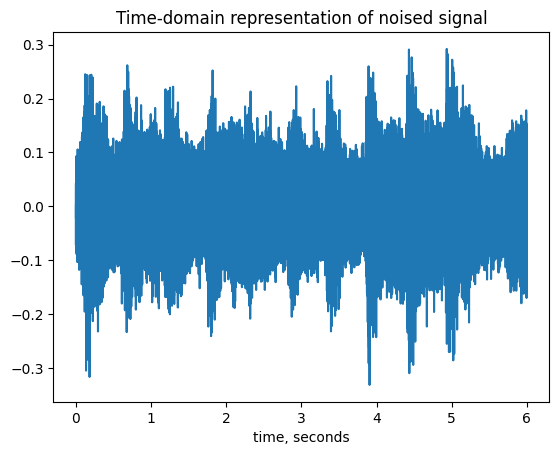

In [7]:
signal = sample + noise

plt.plot(time, signal)
plt.title('Time-domain representation of noised signal')
plt.xlabel('time, seconds')
plt.show()

Audio(signal, rate=sampling_rate)

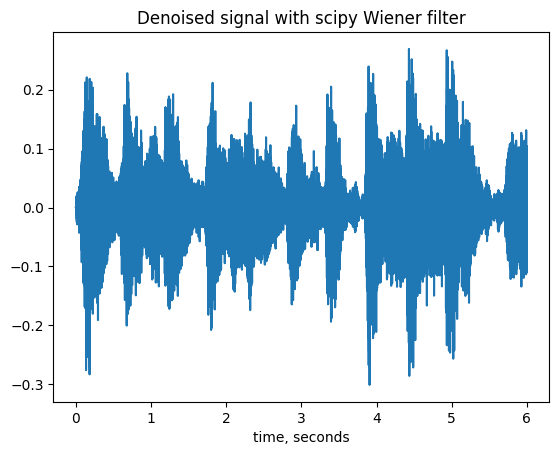

In [8]:
lib_wiener_filtered = wiener(signal, noise=np.var(noise), mysize=500)

plt.plot(time, lib_wiener_filtered)
plt.title('Denoised signal with scipy Wiener filter')
plt.xlabel('time, seconds')
plt.show()

Audio(lib_wiener_filtered, rate=sampling_rate)

In [62]:
def optimal_filter(samples, noise):
    correlation = np.convolve(samples, samples[::-1])
    rxx = correlation[correlation.size//2:]
    autocorrelation_matrix = toeplitz(rxx, np.hstack((rxx[0], rxx[1:])))
    rvv = np.convolve(noise, noise[::-1])
    rvv = rvv[rvv.size//2:]
    cross_correlation_estimate = rxx - rvv
    filter = np.linalg.inv(autocorrelation_matrix).dot(cross_correlation_estimate)
    return filter


def wiener_filter(last_samples, noise_sample):
    filter = optimal_filter(last_samples, noise_sample)
    return filter.transpose().dot(last_samples)

-0.025101623273775162

132300
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
7

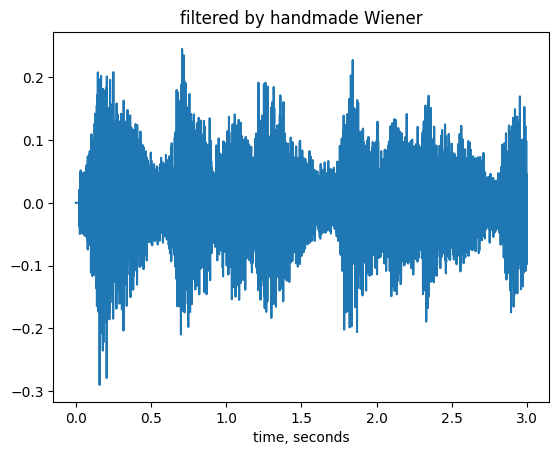

In [68]:
windowsize = 500
print(signal.size)
filtered_us = np.zeros(signal.size//2)
for i in range(windowsize, signal.size//2):
    print(i)
    if i < windowsize:
        filtered_us[i] = wiener_filter(signal[0:i], noise[0:i])
    else:
        filtered_us[i] = wiener_filter(signal[i-windowsize:i], noise[i-windowsize:i])
print(filtered_us)
plt.plot(time[:signal.size//2], filtered_us)
plt.title("filtered by handmade Wiener")
plt.xlabel("time, seconds")
plt.show()



In [70]:
Audio(filtered_us, rate=sampling_rate)